In [1]:
import numpy as np
import pandas as pd
import cupy as cp
import cudf
import dask_cudf as ddf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path= r"/mnt/c/Users/sandi/Desktop/My Git/Netflix Recommender System/data.csv"
data = cudf.read_csv(file_path, nrows= 1000000, names=['Movie_Id', 'User_Id', 'User_Rating', 'Date'])

data.head()

,Movie_Id,User_Id,User_Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [3]:
data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Movie_Id     1000000 non-null  int64
 1   User_Id      1000000 non-null  int64
 2   User_Rating  1000000 non-null  int64
 3   Date         1000000 non-null  object
dtypes: int64(3), object(1)
memory usage: 36.2+ MB


In [4]:
data.nunique()

Movie_Id          225
User_Id        283705
User_Rating         5
Date             2166
dtype: int64

In [5]:
numeric_columns = data.select_dtypes(include=['int64']).columns

# Convert numeric columns to int32
for col in numeric_columns:
    data[col] = data[col].astype('int32')

data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Movie_Id     1000000 non-null  int32
 1   User_Id      1000000 non-null  int32
 2   User_Rating  1000000 non-null  int32
 3   Date         1000000 non-null  object
dtypes: int32(3), object(1)
memory usage: 24.8+ MB


<p style="color: yellow;">By converting to int32 datatype we are saving much memory.</p>


<p style="color: yellow;">The 'Date' column is not in the datetime format so let's convert it into datetime format first.</p>

In [6]:
data['Date'] = cudf.to_datetime(data['Date'])
data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Movie_Id     1000000 non-null  int32
 1   User_Id      1000000 non-null  int32
 2   User_Rating  1000000 non-null  int32
 3   Date         1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 19.1 MB


<p style="color: yellow;">Let's sort the ratings by date in ascending order.</p>

In [7]:
data= data.sort_values(by='Date')
data.head()

,Movie_Id,User_Id,User_Rating,Date
254722,55,1972971,1,1999-12-09
241446,46,510180,3,1999-12-20
290861,77,830363,3,1999-12-21
233922,45,355883,2,1999-12-25
312691,81,1435350,4,1999-12-27


In [8]:
link='/mnt/c/Users/sandi/Desktop/My Git/Netflix Recommender System/movie_titles.csv'

# Read the CSV file line by line and split each line using the first two commas
with open(link, 'r', encoding='ISO-8859-1') as file:
    lines = file.readlines()

data_list = []
for line in lines:
    parts = line.strip().split(',', 2)  # Split into three parts at most: Movie_Id, Year, Movie_Title
    data_list.append(parts)

# Create a DataFrame from the processed data
movie_data = pd.DataFrame(data_list, columns=['Movie_Id', 'Year', 'Movie_Title'])

# Convert 'Movie_Id' and 'Year' columns to appropriate data types
movie_data['Movie_Id'] = movie_data['Movie_Id'].astype(int)
movie_data['Year'] = pd.to_numeric(movie_data['Year'], errors='coerce')

movie_data.head()

,Movie_Id,Year,Movie_Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW



<p style="color: yellow;">Let's load the movie_titles dataframe now</p>

In [9]:
movie_data.shape

(17770, 3)

In [10]:
movie_data.isnull().mean()

Movie_Id       0.000000
Year           0.000394
Movie_Title    0.000000
dtype: float64

As the 'Year' column in movie_data has some null values for now we will fill those values with 0.

In [11]:
movie_data= movie_data.fillna(0)

movie_data.head()

,Movie_Id,Year,Movie_Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [12]:
movie_data.isnull().mean()

Movie_Id       0.0
Year           0.0
Movie_Title    0.0
dtype: float64

In [13]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Movie_Id     17770 non-null  int64  
 1   Year         17770 non-null  float64
 2   Movie_Title  17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


In [14]:
movie_data.memory_usage()

Index             128
Movie_Id       142160
Year           142160
Movie_Title    142160
dtype: int64

In [15]:
type(movie_data)

pandas.core.frame.DataFrame

In [16]:
Unique_Movie_Titles_List = list(data['Movie_Id'].unique().to_pandas())

In [17]:
len(Unique_Movie_Titles_List)

225

In [18]:
# Filter movie_data based on Unique_Movie_Titles_List
filtered_movie_data = movie_data[movie_data['Movie_Id'].isin(Unique_Movie_Titles_List)]

filtered_movie_data.head()


,Movie_Id,Year,Movie_Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [19]:
movie_data_cudf= cudf.from_pandas(filtered_movie_data)

movie_data_cudf.head()

,Movie_Id,Year,Movie_Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [20]:
movie_data_cudf.shape

(225, 3)

In [21]:
from imdb import IMDb

ia = IMDb()

# Searching for the movie
movies = ia.search_movie('Isle of Man TT 2004 Review')

# Assuming you want to work with the first search result
if movies:
    movie = movies[0]

    # Fetching the complete information for the movie
    ia.update(movie, info=['main', 'cast'])

    # Printing the names of the directors of the movie
    print('Directors:')
    for director in movie['directors']:
        print(director['name'])

    # Printing the first three actor names separated by commas
    print('First Three Actors:')
    actor_names = [actor['name'] for actor in movie['cast'][:3]]
    print(', '.join(actor_names))

    # Printing the first three genres separated by commas
    print('First Three Genres:')
    genre_names = movie['genres'][:3]
    print(', '.join(genre_names))

    # Printing the year of release
    print('Year of Release:', movie['year'])
else:
    print('No movie found with the given title.')


2023-08-31 11:36:36,595 ERROR [imdbpy] /home/sandipanarnab/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/imdb/__init__.py:844: unknown information set "cast"


Directors:
David Niblock
First Three Actors:
Simon McGregor-Wood, John Ingram, Gary Johnson
First Three Genres:
Documentary
Year of Release: 2012


In [22]:
from imdb import IMDb

ia = IMDb()

# Searching for the movie
movies = ia.search_movie('The Rise and Fall of ECW')

# Assuming you want to work with the first search result
if movies:
    movie = movies[0]

    # Fetching the complete information for the movie
    ia.update(movie, info=['main', 'cast'])

    # Printing the names of the directors of the movie
    print('Directors:')
    for director in movie['directors']:
        print(director['name'])

    # Printing the first three actor names separated by commas
    print('First Three Actors:')
    actor_names = [actor['name'] for actor in movie['cast'][:3]]
    print(', '.join(actor_names))

    # Printing the first three genres separated by commas
    print('First Three Genres:')
    genre_names = movie['genres'][:3]
    print(', '.join(genre_names))

    # Printing the year of release
    print('Year of Release:', movie['year'])
else:
    print('No movie found with the given title.')

2023-08-31 11:36:41,244 ERROR [imdbpy] /home/sandipanarnab/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/imdb/__init__.py:844: unknown information set "cast"


Directors:
Kevin Dunn
First Three Actors:
Abdullah the Butcher, Donna Adamo, Bill Alfonso
First Three Genres:
Documentary, Sport
Year of Release: 2004


In [23]:
type(movie_data_cudf)

cudf.core.dataframe.DataFrame

In [24]:
movie_data_cudf.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Movie_Id     225 non-null    int64
 1   Year         225 non-null    float64
 2   Movie_Title  225 non-null    object
dtypes: float64(1), int64(1), object(1)
memory usage: 10.8+ KB


In [28]:
from imdb import IMDb, IMDbDataAccessError
import pandas as pd
import cudf

# Create an instance of the IMDb class
ia = IMDb(timeout=30) 

# Define a function to extract and format director names
def get_directors(movie_id):
    movie = ia.get_movie(movie_id)
    directors = movie.get('directors', [])
    director_names = [director.get('name') for director in directors]
    return ", ".join(director_names[:2]) if director_names else None

# Define a function to extract and format actor names
def get_actors(movie_id):
    movie = ia.get_movie(movie_id)
    cast = movie.get('cast', [])
    actor_names = [actor.get('name') for actor in cast[:3]]
    return ", ".join(actor_names)

# Define a function to extract and format genre names
def get_genres(movie_id):
    movie = ia.get_movie(movie_id)
    genres = movie.get('genres', [])
    return ", ".join(genres[:3])

# Define a function to extract and format plot summary
def get_plot_summary(movie_id):
    try:
        movie = ia.get_movie(movie_id)
        plot = movie.get('plot', None)
        return plot[0] if plot else None
    except IMDbDataAccessError as e:
        print(f"Error fetching plot for movie {movie_id}: {e}")
        return None

# Assuming you have a movie_data_cudf cuDF DataFrame
# Convert it to a pandas DataFrame
movie_data_pandas = movie_data_cudf.to_pandas()

# Apply the defined functions using pandas
movie_data_pandas['Director1'] = movie_data_pandas['Movie_Id'].apply(get_directors)
movie_data_pandas[['Actor1', 'Actor2', 'Actor3']] = movie_data_pandas['Movie_Id'].apply(get_actors).str.split(', ', expand=True)
movie_data_pandas[['Genre1', 'Genre2', 'Genre3']] = movie_data_pandas['Movie_Id'].apply(get_genres).str.split(', ', expand=True)
movie_data_pandas['Plot_Summary'] = movie_data_pandas['Movie_Id'].apply(get_plot_summary)

# Convert back to cuDF DataFrame
movie_data_cudf = cudf.from_pandas(movie_data_pandas)

movie_data_cudf.head()

2023-08-31 15:29:58,442 CRITICAL [imdbpy] /home/sandipanarnab/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/imdb/_exceptions.py:32: IMDbDataAccessError exception raised; args: ({'errcode': None, 'errmsg': 'None', 'url': 'https://www.imdb.com/title/tt0000102/plotsummary', 'proxy': '', 'exception type': 'IOError', 'original exception': URLError(gaierror(-3, 'Temporary failure in name resolution'))},); kwds: {}
Traceback (most recent call last):
  File "/home/sandipanarnab/miniconda3/envs/rapids-23.08/lib/python3.9/urllib/request.py", line 1346, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/home/sandipanarnab/miniconda3/envs/rapids-23.08/lib/python3.9/http/client.py", line 1285, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/home/sandipanarnab/miniconda3/envs/rapids-23.08/lib/python3.9/http/client.py", line 1331, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/home/

IMDbDataAccessError: {'errcode': None, 'errmsg': 'None', 'url': 'https://www.imdb.com/title/tt0000102/plotsummary', 'proxy': '', 'exception type': 'IOError', 'original exception': URLError(gaierror(-3, 'Temporary failure in name resolution'))}

In [ ]:
movie_data_cudf.isnull().mean()

Movie_Id       0.000000
Year           0.000000
Movie_Title    0.000000
Director1      0.048889
Actor1         0.000000
Actor2         0.880000
Actor3         0.955556
Genre1         0.000000
Genre2         0.288889
Genre3         0.924444
dtype: float64



<p style="color: yellow;">From the above we can see the column Actor1 is showing to have no null values but still some rows are being displayed as blank, so we need to check for ' ' values in the data, which are not null but still holds no value.</p>

In [ ]:
movie_data_pandas= movie_data_cudf.to_pandas()

null_percentage = (movie_data_pandas.isnull() | (movie_data_pandas == '')).mean()

null_percentage

Movie_Id       0.000000
Year           0.000000
Movie_Title    0.000000
Director1      0.048889
Actor1         0.715556
Actor2         0.880000
Actor3         0.955556
Genre1         0.000000
Genre2         0.288889
Genre3         0.924444
dtype: float64

<p style="color: yellow;">From the above we can see the column Actor1 is showing to have a large number of ' ' values, so we will remove columns with ' ' and NaN values.</p>

In [ ]:
import cudf

threshold = 0.1

# Calculate the percentage of null values in each column
null_percentage = (movie_data_pandas.isnull() | (movie_data_pandas == '')).mean()

# Identify columns with null percentage greater than or equal to the threshold
columns_to_drop = null_percentage[null_percentage >= threshold].index

# Drop specified columns from pandas DataFrame
new_movie_data_pandas = movie_data_pandas.drop(columns=columns_to_drop)

# Convert the resulting pandas DataFrame back to cuDF DataFrame
new_movie_data_cudf = cudf.from_pandas(new_movie_data_pandas)

new_movie_data_cudf.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1
0,1,2003.0,Dinosaur Planet,William K.L. Dickson,Documentary
1,2,2004.0,Isle of Man TT 2004 Review,Émile Reynaud,Animation
2,3,1997.0,Character,Émile Reynaud,Animation
3,4,1994.0,Paula Abdul's Get Up & Dance,Émile Reynaud,Animation
4,5,2004.0,The Rise and Fall of ECW,William K.L. Dickson,Short


In [ ]:
null_percentage = (new_movie_data_pandas.isnull() | (new_movie_data_pandas == '')).sum()

null_percentage

Movie_Id        0
Year            0
Movie_Title     0
Director1      11
Genre1          0
dtype: int64

In [ ]:
type(new_movie_data_pandas)

pandas.core.frame.DataFrame

Those 11 directors can be either filled manually or can be retrieved from somewhere else

In [ ]:
movie_data= cudf.from_pandas(new_movie_data_pandas)

movie_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1
0,1,2003.0,Dinosaur Planet,William K.L. Dickson,Documentary
1,2,2004.0,Isle of Man TT 2004 Review,Émile Reynaud,Animation
2,3,1997.0,Character,Émile Reynaud,Animation
3,4,1994.0,Paula Abdul's Get Up & Dance,Émile Reynaud,Animation
4,5,2004.0,The Rise and Fall of ECW,William K.L. Dickson,Short


In [ ]:
movie_data.shape

(225, 5)

In [ ]:
movie_data.nunique()

Movie_Id       225
Year            47
Movie_Title    225
Director1       33
Genre1           7
dtype: int64

In [ ]:
type(movie_data)

cudf.core.dataframe.DataFrame

In [ ]:
data.head()

,Movie_Id,User_Id,User_Rating,Date
254722,55,1972971,1,1999-12-09
241446,46,510180,3,1999-12-20
290861,77,830363,3,1999-12-21
233922,45,355883,2,1999-12-25
312691,81,1435350,4,1999-12-27


In [ ]:
data.nunique()

Movie_Id          225
User_Id        283705
User_Rating         5
Date             2166
dtype: int64

In [ ]:
type(data)

cudf.core.dataframe.DataFrame

In [ ]:
data.shape

(1000000, 4)

Now we can use this new_movie_data_pandas.csv file to laod into our workspace directly and start work from theere which will save our time.

We will extract some more features using Cinemagoer library.

In [ ]:
# Merge the two cuDF dataframes based on 'Movie_Id'
merged_movie_data = cudf.merge(data, movie_data, on='Movie_Id')

# Reorder columns as per your requirement
desired_columns = ['Movie_Id', 'Year', 'Movie_Title', 'Director1', 'Genre1', 'User_Id', 'User_Rating', 'Date']
merged_movie_data = merged_movie_data[desired_columns]

merged_movie_data['Date'] = cudf.to_datetime(merged_movie_data['Date'])

merged_movie_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
0,199,1978.0,The Deer Hunter,<NA>,Short,1301357,4,2000-02-26
1,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26
2,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27
4,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27


In [ ]:
merged_movie_data.nunique()

Movie_Id          225
Year               47
Movie_Title       225
Director1          33
Genre1              7
User_Id        283705
User_Rating         5
Date             2166
dtype: int64

In [ ]:
merged_movie_data.isnull().mean()

Movie_Id       0.000000
Year           0.000000
Movie_Title    0.000000
Director1      0.050848
Genre1         0.000000
User_Id        0.000000
User_Rating    0.000000
Date           0.000000
dtype: float64

In [ ]:
merged_movie_data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Movie_Id     1000000 non-null  int64
 1   Year         1000000 non-null  float64
 2   Movie_Title  1000000 non-null  object
 3   Director1    949152 non-null   object
 4   Genre1       1000000 non-null  object
 5   User_Id      1000000 non-null  int32
 6   User_Rating  1000000 non-null  int32
 7   Date         1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(3)
memory usage: 78.6+ MB


In order to fill those director names we can take help of CatBoost which we will do later.

There is some null value in the 'Year' column but there are no null values in 'Movie_Id' and Movie_Title' column thus there may be same Movie_Id for more than one Movie_Title. Let's check it.

In [ ]:
# Group by Movie_Title and check the number of unique Movie_Id values
title_id_counts = merged_movie_data.groupby('Movie_Title')['Movie_Id'].nunique()

# Filter titles with more than one unique Movie_Id
titles_with_multiple_ids = title_id_counts[title_id_counts > 1]

# Print the titles and the associated counts
print("Movie Titles with Multiple Movie Ids:")
print(titles_with_multiple_ids)
len(merged_movie_data)

Movie Titles with Multiple Movie Ids:
Series([], Name: Movie_Id, dtype: int32)


1000000

In [ ]:
# Convert cuDF DataFrame to pandas DataFrame
merged_movie_data_pandas = merged_movie_data.to_pandas()

# Group by Movie_Title and get the list of unique Movie_Id values
title_id_lists = merged_movie_data_pandas.groupby('Movie_Title')['Movie_Id'].unique()

# Filter titles with more than one unique Movie_Id
titles_with_multiple_ids = title_id_lists[title_id_lists.apply(len) > 1]

print("the number of movies with non-unique Movie_Ids are: ", len(titles_with_multiple_ids))

# Print the titles and the corresponding Movie_Id lists
for title, ids in titles_with_multiple_ids.items():
    print(f"Movie Title: {title}, Movie Ids: {ids}")


the number of movies with non-unique Movie_Ids are:  0


So as we can see there are 7 movies which has two or more Movie_Ids, so it would be better to retain only one of their Movie_Id by replacing with the other (preferably the first one).

In [ ]:
# Mapping of Movie_Title to the corresponding first Movie_Id
first_ids_mapping = merged_movie_data_pandas.drop_duplicates(subset=['Movie_Title']).set_index('Movie_Title')['Movie_Id']

# Update Movie_Id values for duplicates
merged_movie_data_pandas['Movie_Id'] = merged_movie_data_pandas['Movie_Title'].map(first_ids_mapping)

merged_movie_data_pandas.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
0,199,1978.0,The Deer Hunter,None,Short,1301357,4,2000-02-26
1,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26
2,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27
4,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27


In [ ]:
merged_movie_data_pandas.nunique()

Movie_Id          225
Year               47
Movie_Title       225
Director1          33
Genre1              7
User_Id        283705
User_Rating         5
Date             2166
dtype: int64

Now the number of unique Movie_Id and Movie_Title do match

In [ ]:
merged_movie_data_pandas.isnull().mean()

Movie_Id       0.000000
Year           0.000000
Movie_Title    0.000000
Director1      0.050848
Genre1         0.000000
User_Id        0.000000
User_Rating    0.000000
Date           0.000000
dtype: float64

In [ ]:
deduplicated_data = merged_movie_data_pandas.drop_duplicates()

deduplicated_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
0,199,1978.0,The Deer Hunter,None,Short,1301357,4,2000-02-26
1,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26
2,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27
4,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27


In [ ]:
duplicate_rows_deleted= merged_movie_data_pandas.shape[0]- deduplicated_data.shape[0]
print("Number of dulicate rows deleted=", duplicate_rows_deleted)

Number of dulicate rows deleted= 0


In [ ]:
merged_movie_data_pandas= deduplicated_data

merged_movie_data_pandas.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
0,199,1978.0,The Deer Hunter,None,Short,1301357,4,2000-02-26
1,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26
2,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27
4,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27


In [ ]:
merged_movie_data= cudf.from_pandas(merged_movie_data_pandas)

merged_movie_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
0,199,1978.0,The Deer Hunter,<NA>,Short,1301357,4,2000-02-26
1,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26
2,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27
4,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27


In [ ]:
merged_movie_data= merged_movie_data.reset_index(drop=True)

merged_movie_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
0,199,1978.0,The Deer Hunter,<NA>,Short,1301357,4,2000-02-26
1,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26
2,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27
4,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27


In [ ]:
merged_movie_data.shape

(1000000, 8)

In [ ]:
# Convert cuDF dataframes to pandas DataFrames
merged_movie_data_pd = merged_movie_data.to_pandas()

null_percentage = (merged_movie_data_pd.isnull() | (merged_movie_data_pd == '')).mean()

null_percentage

Movie_Id       0.000000
Year           0.000000
Movie_Title    0.000000
Director1      0.050848
Genre1         0.000000
User_Id        0.000000
User_Rating    0.000000
Date           0.000000
dtype: float64

In [ ]:
merged_movie_data.isnull().sum()

Movie_Id           0
Year               0
Movie_Title        0
Director1      50848
Genre1             0
User_Id            0
User_Rating        0
Date               0
dtype: int64

In [ ]:
merged_movie_data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Movie_Id     1000000 non-null  int64
 1   Year         1000000 non-null  float64
 2   Movie_Title  1000000 non-null  object
 3   Director1    949152 non-null   object
 4   Genre1       1000000 non-null  object
 5   User_Id      1000000 non-null  int32
 6   User_Rating  1000000 non-null  int32
 7   Date         1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(3)
memory usage: 78.6+ MB


In [ ]:
merged_movie_data['Movie_Id'] = merged_movie_data['Movie_Id'].astype(str)
merged_movie_data['Year'] = merged_movie_data['Year'].astype(str)

In [ ]:
merged_movie_data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Movie_Id     1000000 non-null  object
 1   Year         1000000 non-null  object
 2   Movie_Title  1000000 non-null  object
 3   Director1    949152 non-null   object
 4   Genre1       1000000 non-null  object
 5   User_Id      1000000 non-null  int32
 6   User_Rating  1000000 non-null  int32
 7   Date         1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), object(5)
memory usage: 77.3+ MB


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import pandas as pd

# Convert cuDF dataframes to pandas DataFrames
imputed_movie_data_pd = imputed_movie_data.to_pandas()

# Step 1: Divide the dataset into two parts: filled and missing
filled_data = imputed_movie_data_pd.dropna(subset=['Director1'])
missing_data = imputed_movie_data_pd[imputed_movie_data_pd['Director1'].isnull()]

# Step 2: Rename the missing dataset as imputation_test_data
imputation_test_data = missing_data.copy()

# Step 3: Divide the filled dataset into imputation_train_data and imputation_cv_data
imputation_train_data, imputation_cv_data = train_test_split(filled_data, test_size=0.2, random_state=42)

# Separate features and target for imputation_train_data
X_imputation_train = imputation_train_data[['User_Rating', 'Genre1', 'User_Id', 'Year']]
y_imputation_train = imputation_train_data['Director1']

# Separate features and target for imputation_cv_data
X_imputation_cv = imputation_cv_data[['User_Rating', 'Genre1', 'User_Id', 'Year']]
y_imputation_cv = imputation_cv_data['Director1']

# Convert 'Year' column to string
X_imputation_train['Year'] = X_imputation_train['Year'].astype(str)
X_imputation_cv['Year'] = X_imputation_cv['Year'].astype(str)

# Create and train a CatBoost model
model_cat = CatBoostClassifier(iterations=500, learning_rate=0.05, cat_features=['Genre1', 'User_Id', 'Year'], task_type='GPU', verbose=10)
model_cat.fit(X_imputation_train, y_imputation_train, eval_set=(X_imputation_cv, y_imputation_cv))

# Evaluate the model on validation data
y_pred_cv = model_cat.predict(X_imputation_cv)
accuracy = accuracy_score(y_imputation_cv, y_pred_cv)
f1 = f1_score(y_imputation_cv, y_pred_cv, average='weighted')
recall = recall_score(y_imputation_cv, y_pred_cv, average='weighted')
precision = precision_score(y_imputation_cv, y_pred_cv, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

/tmp/ipykernel_964/3322033879.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_imputation_train['Year'] = X_imputation_train['Year'].astype(str)
/tmp/ipykernel_964/3322033879.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_imputation_cv['Year'] = X_imputation_cv['Year'].astype(str)


0:	learn: 2.3932240	test: 2.3902649	best: 2.3902649 (0)	total: 305ms	remaining: 2m 32s
10:	learn: 1.2150045	test: 1.1968680	best: 1.1968680 (10)	total: 3.21s	remaining: 2m 22s
20:	learn: 0.8644104	test: 0.8446393	best: 0.8446393 (20)	total: 6.05s	remaining: 2m 18s
30:	learn: 0.6676855	test: 0.6501889	best: 0.6501889 (30)	total: 8.86s	remaining: 2m 14s
40:	learn: 0.5629836	test: 0.5458706	best: 0.5458706 (40)	total: 11.6s	remaining: 2m 10s
50:	learn: 0.4943589	test: 0.4824271	best: 0.4824271 (50)	total: 14.5s	remaining: 2m 7s
60:	learn: 0.4547388	test: 0.4466510	best: 0.4466510 (60)	total: 17.3s	remaining: 2m 4s
70:	learn: 0.4313885	test: 0.4235543	best: 0.4235543 (70)	total: 20s	remaining: 2m
80:	learn: 0.4147256	test: 0.4077434	best: 0.4077434 (80)	total: 22.8s	remaining: 1m 57s
90:	learn: 0.4001111	test: 0.3939244	best: 0.3939244 (90)	total: 25.5s	remaining: 1m 54s
100:	learn: 0.3879028	test: 0.3826186	best: 0.3826186 (100)	total: 28.3s	remaining: 1m 51s
110:	learn: 0.3775783	test: 0

/home/sandipanarnab/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<span style="color: yellow;"> The accuracy looks good we can sue this model to predict the null values in our 'Director1' column.</span>

In [ ]:
# Step 4: Predict missing 'Director1' values for imputation_test_data
X_imputation_test = imputation_test_data[['User_Rating', 'Genre1', 'User_Id', 'Year']]

# Convert 'Year' column to string
X_imputation_test['Year'] = X_imputation_test['Year'].astype(str)
X_imputation_test['User_Id'] = X_imputation_test['User_Id'].astype(str)

missing_directors_test = model_cat.predict(X_imputation_test)
missing_directors_test = missing_directors_test.argmax(axis=1)  # Get the class with highest probability
imputation_test_data['Director1'] = missing_directors_test

# Merge imputation_test_data with filled_data to produce the final imputed_data dataframe
imputed_data = pd.concat([filled_data, imputation_test_data], ignore_index=True)

imputed_data.head()

/tmp/ipykernel_964/185552137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_imputation_test['Year'] = X_imputation_test['Year'].astype(str)
/tmp/ipykernel_964/185552137.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_imputation_test['User_Id'] = X_imputation_test['User_Id'].astype(str)


,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
0,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26
1,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27
2,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27
4,61,1999.0,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2000-02-27


In [ ]:
imputed_data.isnull().mean()

Movie_Id       0.0
Year           0.0
Movie_Title    0.0
Director1      0.0
Genre1         0.0
User_Id        0.0
User_Rating    0.0
Date           0.0
dtype: float64

In [ ]:
imputed_data.shape

(1000000, 8)

<span style="color: yellow;"> The imputed dataframe looks good. we will save it to a location in local disk so that we can begin our work right form there to save our time</span>

In [63]:
import os

csv_file_path = '/mnt/c/Users/sandi/Desktop/My Git/Netflix Recommender System/imputed_data.csv'

# Check if the CSV file exists
if os.path.exists(csv_file_path):
    # Load the existing CSV file
    imputed_data = pd.read_csv(csv_file_path)
    print("Loaded existing CSV file.")
else:
    
    # Save the DataFrame to CSV
    imputed_data.to_csv(csv_file_path, index=False)
    print("Generated and saved CSV file.")

merged_movie_data= imputed_data

merged_movie_data.head()

Loaded existing CSV file.


/tmp/ipykernel_1007/415650940.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imputed_data = pd.read_csv(csv_file_path)


,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
0,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26
1,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27
2,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27
4,61,1999.0,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2000-02-27


<span style="color: yellow;"> As we have the merged data at this time it would better to separate the dataset into train and test set. We will divide the dataset into time based splitting with 80% data as train data and 20% data as test data. A time based splitting is preferred here as new movies and users get added with time which can be recommended to the existing and new users based on previous ratings on eisting movies.</span>


In [64]:
merged_movie_data= merged_movie_data.reset_index(drop=True)

split_index = int(len(merged_movie_data) * 0.8)

# Split the dataset into train and test sets
train_data = merged_movie_data[:split_index]
test_data = merged_movie_data[split_index:]

# Print the shapes of the train and test sets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (800000, 8)
Test data shape: (200000, 8)


In [31]:
merged_movie_data.isnull().mean()

Movie_Id       0.0
Year           0.0
Movie_Title    0.0
Director1      0.0
Genre1         0.0
User_Id        0.0
User_Rating    0.0
Date           0.0
dtype: float64

In [32]:
avg_user_rating= round(train_data['User_Rating'].mean(), 6)

print("The average user rating is:", avg_user_rating)

The average user rating is: 3.612205


In [33]:
type(train_data)

pandas.core.frame.DataFrame

In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Movie_Id     800000 non-null  int64  
 1   Year         800000 non-null  float64
 2   Movie_Title  800000 non-null  object 
 3   Director1    800000 non-null  object 
 4   Genre1       800000 non-null  object 
 5   User_Id      800000 non-null  int64  
 6   User_Rating  800000 non-null  int64  
 7   Date         800000 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 48.8+ MB


In [39]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.loc[:, 'day_of_week'] = train_data['Date'].dt.day_name()

train_data.head()

/tmp/ipykernel_1007/8885481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Date'] = pd.to_datetime(train_data['Date'])
/tmp/ipykernel_1007/8885481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'day_of_week'] = train_data['Date'].dt.day_name()


,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,day_of_week
0,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26,Saturday
1,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27,Sunday
2,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27,Sunday
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27,Sunday
4,61,1999.0,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2000-02-27,Sunday


/tmp/ipykernel_1007/1169264591.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(formatted_y_ticks)


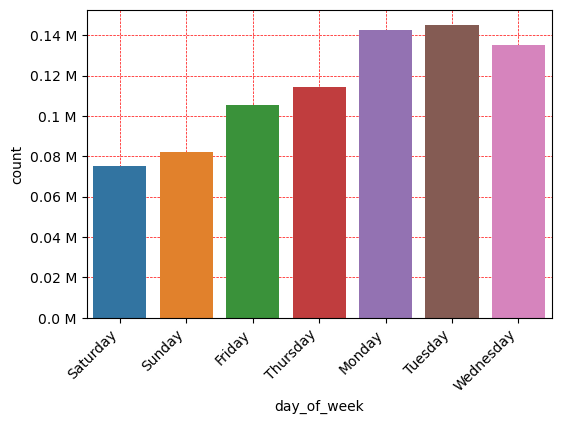

In [40]:
# Create a count plot using Seaborn
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=train_data, x='day_of_week')

# Format y-axis labels using the readable function
def readable(num, units='M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num / 10**3) + " K"
    elif units == 'm':
        return str(num / 10**6) + " M"
    elif units == 'b':
        return str(num / 10**9) + " B"

# Get y-axis ticks
y_ticks = ax.get_yticks()
formatted_y_ticks = [readable(y) for y in y_ticks]

# Set formatted y-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_yticklabels(formatted_y_ticks)

# Set grid lines to be rendered below other plot elements
ax.set_axisbelow(True)

# Add grid lines with red color
ax.grid(True, color='red', linestyle='--', linewidth=0.5)

plt.show()

From the above analysis it shows that people watch more movies/ tv shows on weekdays while on weekends the number of ratings are fewer.

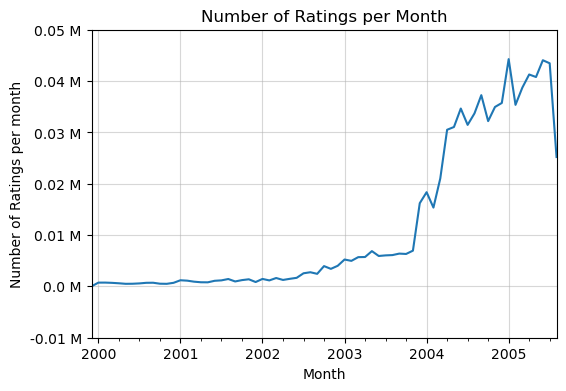

In [41]:
plt.figure(figsize=(6, 4))
ax = train_data.resample('M', on='Date')['User_Rating'].count().plot()

ax.set_title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings per month')

# Format y-axis labels using the readable function
y_ticks = ax.get_yticks()
y_labels = [readable(value, 'M') for value in y_ticks]

# Set y-axis tick positions and labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

# Customize other plot elements
ax.grid(True, alpha=0.5)
plt.axhline(y=y_ticks[-1], color='red', alpha=0.5, linewidth=0.5, linestyle='--')

plt.show()

Let's analyse the ratings by users, first let's check the most ratings then we will see the average number of ratings per user.

In [42]:
no_of_ratings_by_user= train_data.groupby(by='User_Id')['User_Rating'].count().sort_values(ascending=False)

print("The number of ratings by users are arranged in descending order as follows:")

no_of_ratings_by_user

The number of ratings by users are arranged in descending order as follows:


User_Id
305344     206
2439493    192
387418     186
1461435    114
1639792    109
          ... 
1727094      1
598208       1
598238       1
1727026      1
1320871      1
Name: User_Rating, Length: 242191, dtype: int64

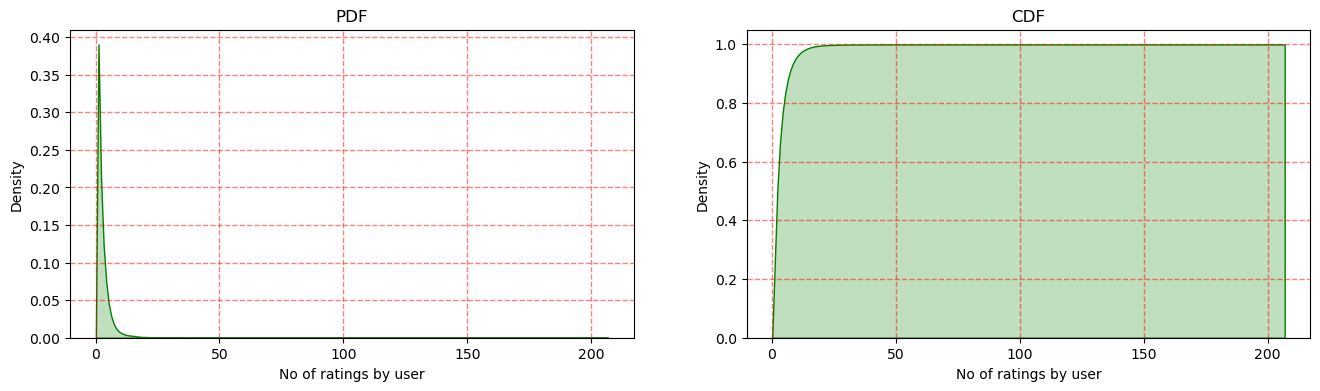

In [43]:
fig = plt.figure(figsize=plt.figaspect(.25))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_by_user, fill=True, color='green', ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_ratings_by_user, fill=True, color='green', cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

ax1.grid(True)
ax2.grid(True)

# Set grid line properties
ax1.grid(color='red', alpha=0.5, linewidth=1, linestyle='--')
ax2.grid(color='red', alpha=0.5, linewidth=1, linestyle='--')

plt.show()

Let's analyse the rating given by a single user.

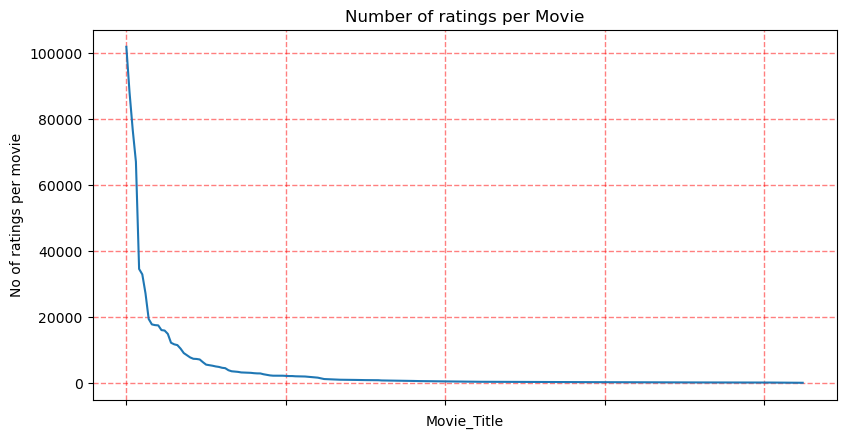

In [44]:
no_of_ratings_per_movie = train_data.groupby(by='Movie_Id')['User_Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('Number of ratings per Movie')
plt.xlabel('Movie_Title')
plt.ylabel('No of ratings per movie')
ax.set_xticklabels([])

ax.grid(True)
ax.grid(color='red', alpha=0.5, linewidth=1, linestyle='--')

plt.show()

<span style="color: yellow;">The graph above shows there are some movies which has received a large number of ratings while there are movies which has received very few ratings. If the number of ratings correlates to number of times the movie has been watched then it dircetly translates to some movies are very popular thus has been watched many times/ by many users while other movies are not that popular.</span>


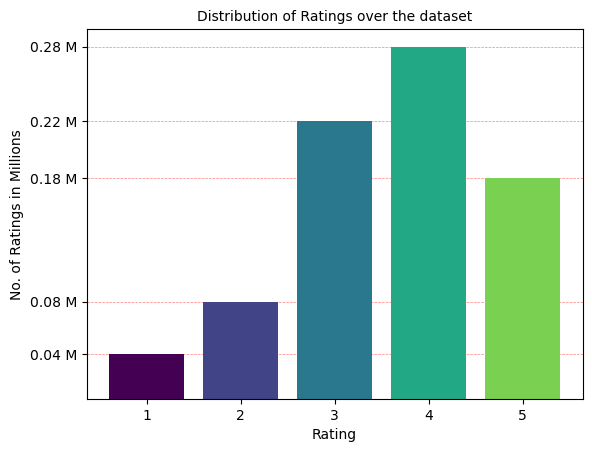

In [45]:
fig, ax = plt.subplots()
plt.title('Distribution of Ratings over the dataset', fontsize=10)

def readable(num, units='M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return "{:.2f} K".format(num / 10**3)
    elif units == 'm':
        return "{:.2f} M".format(num / 10**6)
    elif units == 'b':
        return "{:.2f} B".format(num / 10**9)

# Calculate value counts and sort by index (rating values)
rating_counts = train_data['User_Rating'].value_counts().sort_index()

y_ticks = rating_counts.values
y_labels = [readable(round(value, 2), 'M') for value in y_ticks]

# Create grid lines as horizontal lines
for y_tick in y_ticks:
    ax.axhline(y_tick, color='red', alpha=0.5, linewidth=0.5, linestyle='--', zorder=0)

# Plot bars on top of the grid lines
plt.bar(rating_counts.index, rating_counts.values, color=[plt.cm.viridis(idx / len(rating_counts)) for idx in range(len(rating_counts))], zorder=1)
plt.ylabel('No. of Ratings in Millions')
plt.xlabel('Rating')

# Manually set y-axis tick labels
plt.yticks(y_ticks, y_labels)

plt.show()


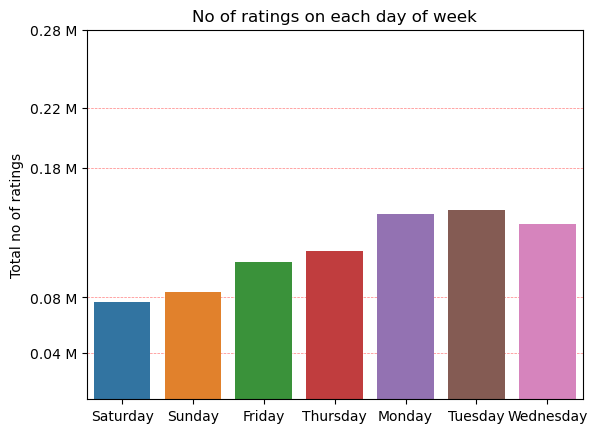

In [46]:
fig, ax = plt.subplots()

sns.countplot(x='day_of_week', data=train_data, ax=ax)

plt.title('No of ratings on each day of week')
plt.xlabel('')
plt.ylabel('Total no of ratings')

# Adjust y-axis range to start from 0
ax.set_ylim(bottom=0)

# Get y-ticks and format using the readable function
y_ticks = train_data['User_Rating'].value_counts().sort_index().values
y_labels = [readable(y) for y in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

# Add horizontal grid lines and set them behind the bars
for y in y_ticks:
    ax.axhline(y, color='red', alpha=0.5, linewidth=0.5, linestyle='--', zorder=-1)

plt.show()


In [47]:
avg_rating_per_day = train_data.groupby(by=['day_of_week'])['User_Rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(round(avg_rating_per_day, 6))
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.610732
Monday       3.612691
Saturday     3.622375
Sunday       3.617416
Thursday     3.611306
Tuesday      3.607626
Wednesday    3.609691
Name: User_Rating, dtype: float64




In [48]:
print("The number of users in the train datset is:", train_data['User_Id'].nunique())
print("The number of movies in the train datset is:", train_data['Movie_Id'].nunique())

The number of users in the train datset is: 242191
The number of movies in the train datset is: 213


In [49]:
print("The total number of ratings by users in the train dataset is:", len(train_data['User_Rating']))

The total number of ratings by users in the train dataset is: 800001


In [50]:
rated_percentage= round(((len(train_data['User_Rating'])/(train_data['User_Id'].nunique()))/(train_data['Movie_Id'].nunique()))*100, 6)

print("So the percentage of rated movies are:", rated_percentage)

So the percentage of rated movies are: 1.55079


In [65]:
# Calculate average rating for each movie
average_ratings_each_movie = train_data.groupby(['Movie_Title', 'Genre1', 'Director1'])['User_Rating'].transform('mean')

# Calculate average rating given by each user
average_ratings_each_user = train_data.groupby(['User_Id', 'Genre1', 'Director1'])['User_Rating'].transform('mean')

# Add new columns for average ratings
train_data['average_ratings_each_movie'] = average_ratings_each_movie
train_data['average_ratings_each_user'] = average_ratings_each_user

train_data.head()

/tmp/ipykernel_1007/3415098465.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_ratings_each_movie'] = average_ratings_each_movie
/tmp/ipykernel_1007/3415098465.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_ratings_each_user'] = average_ratings_each_user


,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,average_ratings_each_movie,average_ratings_each_user
0,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26,3.293422,1.0
1,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27,3.780861,3.0
2,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27,3.779148,3.0
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27,3.779148,2.5
4,61,1999.0,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2000-02-27,2.934783,3.0


In [66]:
# Calculate probabilities for each user rating, genre, and director
proba_Director1 = train_data.groupby(['Director1', 'User_Rating']).size().div(len(train_data)).reset_index()
proba_Genre1 = train_data.groupby(['Genre1', 'User_Rating']).size().div(len(train_data)).reset_index()

# Merge probabilities back to the train_data_new dataframe for Director1
train_data = train_data.merge(proba_Director1, on=['Director1', 'User_Rating'], how='left')
train_data.rename(columns={0: 'director_rating_proba'}, inplace=True)

# Merge probabilities back to the train_data_new dataframe for Genre1
train_data = train_data.merge(proba_Genre1, on=['Genre1', 'User_Rating'], how='left')
train_data.rename(columns={0: 'genre_rating_proba'}, inplace=True)

train_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26,3.293422,1.0,0.001160,0.001140
1,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27,3.780861,3.0,0.003348,0.142478
2,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27,3.779148,3.0,0.055164,0.101187
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27,3.779148,2.5,0.055164,0.101187
4,61,1999.0,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2000-02-27,2.934783,3.0,0.001916,0.142478


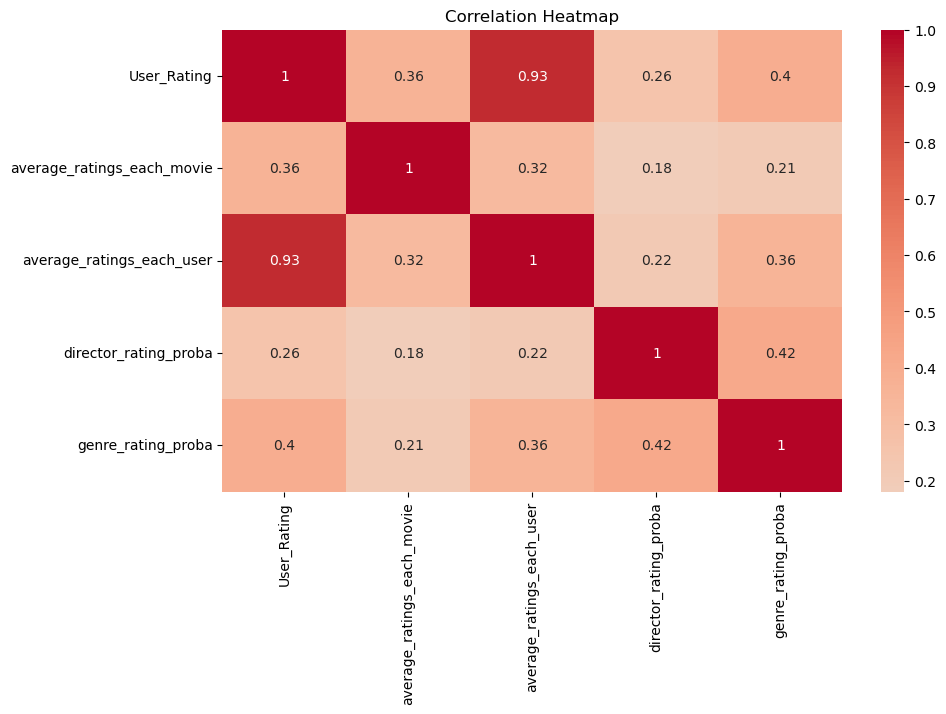

In [68]:
# Select the columns for the heatmap
heatmap_data = train_data[['User_Rating', 'average_ratings_each_movie', 'average_ratings_each_user', 'director_rating_proba', 'genre_rating_proba']]

# Calculate the correlation matrix
correlation_matrix = heatmap_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

<span style="color: yellow;">Above heatmap shows that there is a strong correlation between 'User_Rating' and 'avge_ratings_per_user' while other correlations are not that significant.</span>

In [69]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 0 to 799999
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Movie_Id                    800000 non-null  int64  
 1   Year                        800000 non-null  float64
 2   Movie_Title                 800000 non-null  object 
 3   Director1                   800000 non-null  object 
 4   Genre1                      800000 non-null  object 
 5   User_Id                     800000 non-null  int64  
 6   User_Rating                 800000 non-null  int64  
 7   Date                        800000 non-null  object 
 8   average_ratings_each_movie  800000 non-null  float64
 9   average_ratings_each_user   800000 non-null  float64
 10  director_rating_proba       800000 non-null  float64
 11  genre_rating_proba          800000 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 79.3+ MB


<span style="color: yellow;"> We need to convert all 'int64' and 'flost64' type columns to 'int32' and 'float32' type.</span>

In [70]:
# Convert int64 columns to int32
int_columns = train_data.select_dtypes(include=['int64']).columns
train_data[int_columns] = train_data[int_columns].astype('int32')

# Convert float64 columns to float32
float_columns = train_data.select_dtypes(include=['float64']).columns
train_data[float_columns] = train_data[float_columns].astype('float32')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 0 to 799999
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Movie_Id                    800000 non-null  int32  
 1   Year                        800000 non-null  float32
 2   Movie_Title                 800000 non-null  object 
 3   Director1                   800000 non-null  object 
 4   Genre1                      800000 non-null  object 
 5   User_Id                     800000 non-null  int32  
 6   User_Rating                 800000 non-null  int32  
 7   Date                        800000 non-null  object 
 8   average_ratings_each_movie  800000 non-null  float32
 9   average_ratings_each_user   800000 non-null  float32
 10  director_rating_proba       800000 non-null  float32
 11  genre_rating_proba          800000 non-null  float32
dtypes: float32(5), int32(3), object(4)
memory usage: 54.9+ MB


In [71]:
train_data.nunique()

Movie_Id                         213
Year                              47
Movie_Title                      213
Director1                         33
Genre1                             7
User_Id                       242191
User_Rating                        5
Date                            2031
average_ratings_each_movie       212
average_ratings_each_user        156
director_rating_proba            153
genre_rating_proba                33
dtype: int64

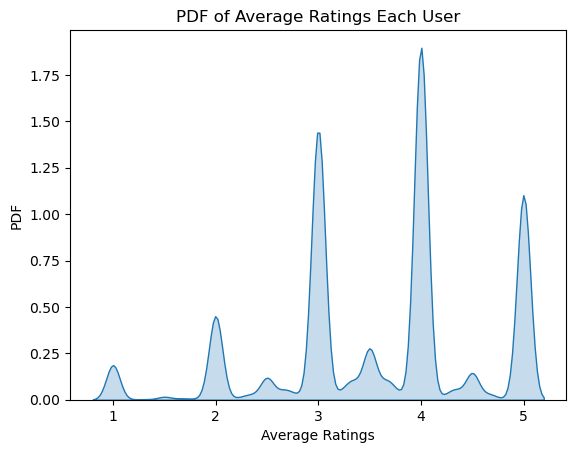

In [72]:
sns.kdeplot(train_data['average_ratings_each_user'], fill=True)
plt.xlabel('Average Ratings')
plt.ylabel('PDF')
plt.title('PDF of Average Ratings Each User')
plt.show()

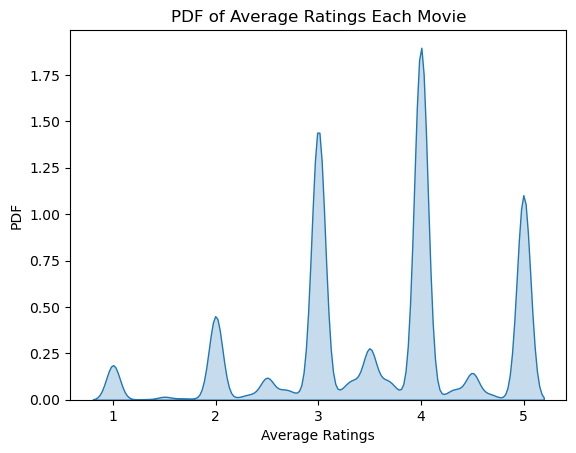

In [73]:
sns.kdeplot(train_data['average_ratings_each_user'], fill=True)
plt.xlabel('Average Ratings')
plt.ylabel('PDF')
plt.title('PDF of Average Ratings Each Movie')
plt.show()

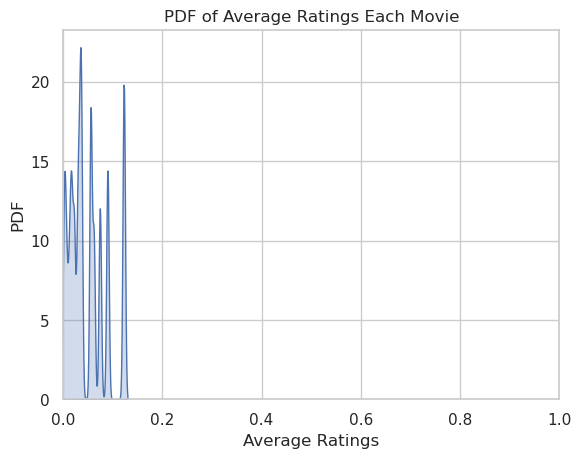

In [76]:
sns.kdeplot(train_data['director_rating_proba'], fill=True)
plt.xlabel('Average Ratings')
plt.ylabel('PDF')
plt.title('PDF of Average Ratings Each Movie')

# Set x-axis limits to 0 and 1
plt.xlim(0, 1)

plt.show()

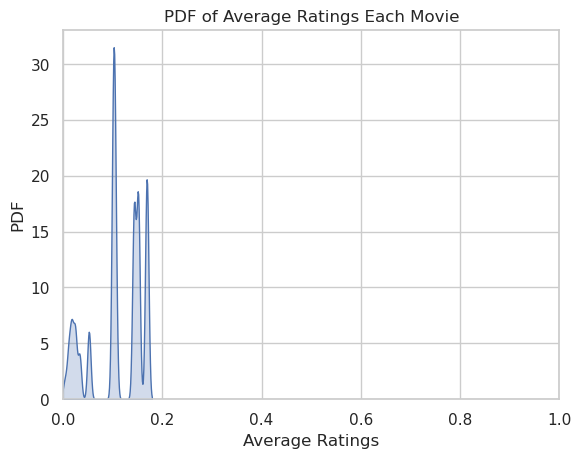

In [77]:
sns.kdeplot(train_data['genre_rating_proba'], fill=True)
plt.xlabel('Average Ratings')
plt.ylabel('PDF')
plt.title('PDF of Average Ratings Each Movie')

# Set x-axis limits to 0 and 1
plt.xlim(0, 1)

plt.show()

In [80]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

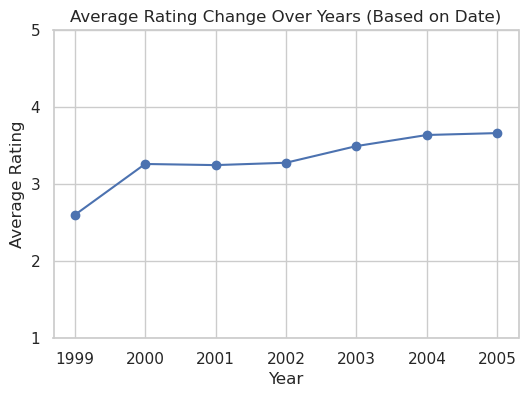

In [81]:
# Calculate average ratings by year
average_ratings_by_year = train_data.groupby(train_data['Date'].dt.year)['User_Rating'].mean()

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_year.index, average_ratings_by_year.values, marker='o')
plt.title('Average Rating Change Over Years (Based on Date)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(range(min(average_ratings_by_year.index), max(average_ratings_by_year.index)+1))
plt.yticks(range(1, 6))
plt.grid(True)
plt.show()

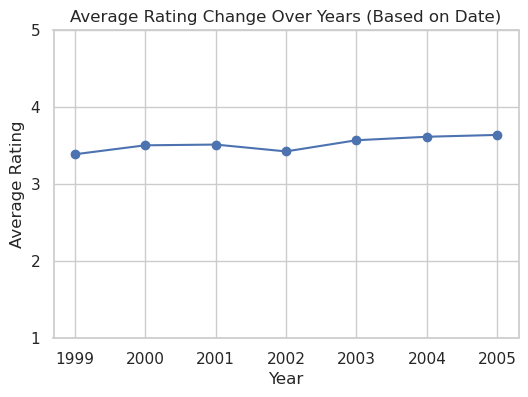

In [82]:
# Calculate average ratings by year
average_ratings_by_year = train_data.groupby(train_data['Date'].dt.year)['average_ratings_each_movie'].mean()

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_year.index, average_ratings_by_year.values, marker='o')
plt.title('Average Rating Change Over Years (Based on Date)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(range(min(average_ratings_by_year.index), max(average_ratings_by_year.index)+1))
plt.yticks(range(1, 6))
plt.grid(True)
plt.show()

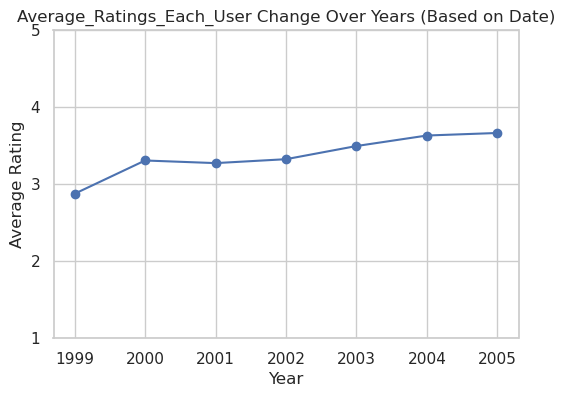

In [83]:
# Calculate average ratings by year
average_ratings_by_year = train_data.groupby(train_data['Date'].dt.year)['average_ratings_each_user'].mean()

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_year.index, average_ratings_by_year.values, marker='o')
plt.title('Average_Ratings_Each_User Change Over Years (Based on Date)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(range(min(average_ratings_by_year.index), max(average_ratings_by_year.index)+1))
plt.yticks(range(1, 6))
plt.grid(True)
plt.show()

<span style="color: yellow;"> The above plots shows that while the average 'user_rating' and 'average_ratings_each_user' have changed with year but 'average_ratings_each_movie' hasn't changed much.

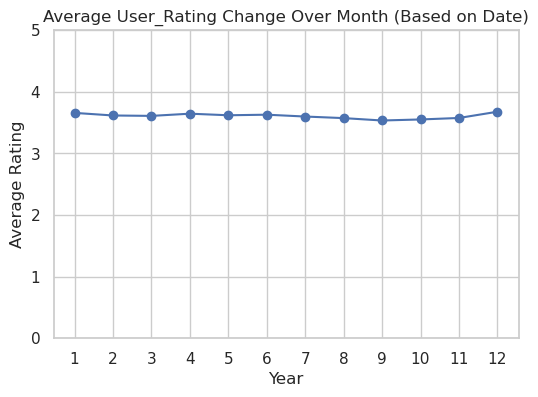

In [84]:
average_ratings_by_month = train_data.groupby(train_data['Date'].dt.month)['User_Rating'].mean()

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_month.index, average_ratings_by_month.values, marker='o')
plt.title('Average User_Rating Change Over Month (Based on Date)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(range(min(average_ratings_by_month.index), max(average_ratings_by_month.index)+1))
plt.yticks(range(0, 6))
plt.grid(True)
plt.show()

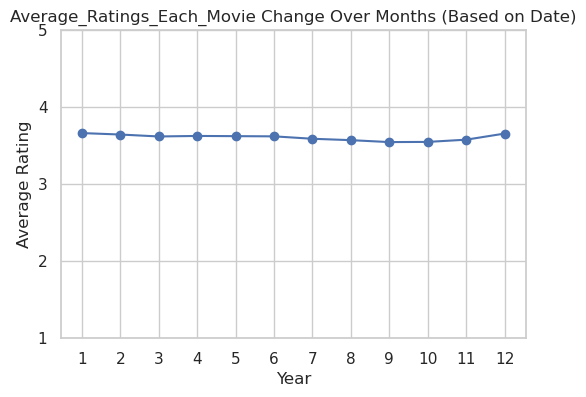

In [85]:
# Calculate average ratings by year
average_ratings_by_month = train_data.groupby(train_data['Date'].dt.month)['average_ratings_each_movie'].mean()

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_month.index, average_ratings_by_month.values, marker='o')
plt.title('Average_Ratings_Each_Movie Change Over Months (Based on Date)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(range(min(average_ratings_by_month .index), max(average_ratings_by_month.index)+1))
plt.yticks(range(1, 6))
plt.grid(True)
plt.show()

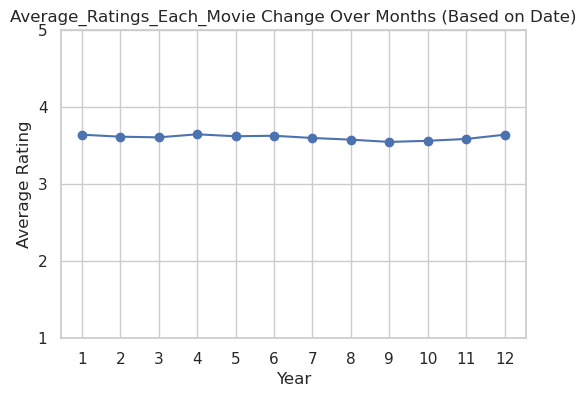

In [86]:
# Calculate average ratings by year
average_ratings_by_month = train_data.groupby(train_data['Date'].dt.month)['average_ratings_each_user'].mean()

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_month.index, average_ratings_by_month.values, marker='o')
plt.title('Average_Ratings_Each_Movie Change Over Months (Based on Date)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(range(min(average_ratings_by_month .index), max(average_ratings_by_month.index)+1))
plt.yticks(range(1, 6))
plt.grid(True)
plt.show()

<span style="color: yellow;"> The above plots show that while the average 'user_rating', 'average_ratings_each_user' and 'average_ratings_each_movie' doesn't chnage much over the month.

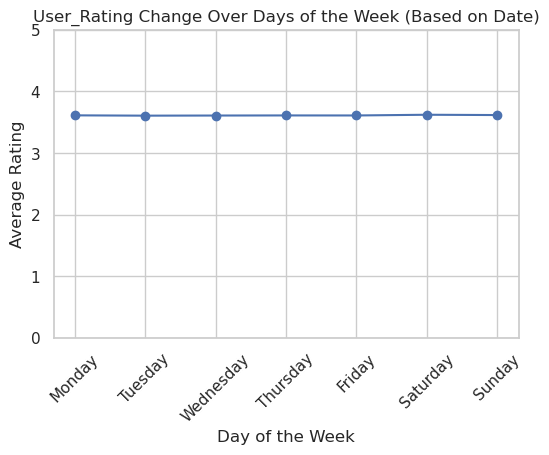

In [87]:
average_ratings_by_day = train_data.groupby(train_data['Date'].dt.dayofweek)['User_Rating'].mean()

# Rename the index to days of the week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_ratings_by_day.index = day_names

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_day.index, average_ratings_by_day.values, marker='o')
plt.title('User_Rating Change Over Days of the Week (Based on Date)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.yticks(range(0, 6))
plt.grid(True)
plt.show()

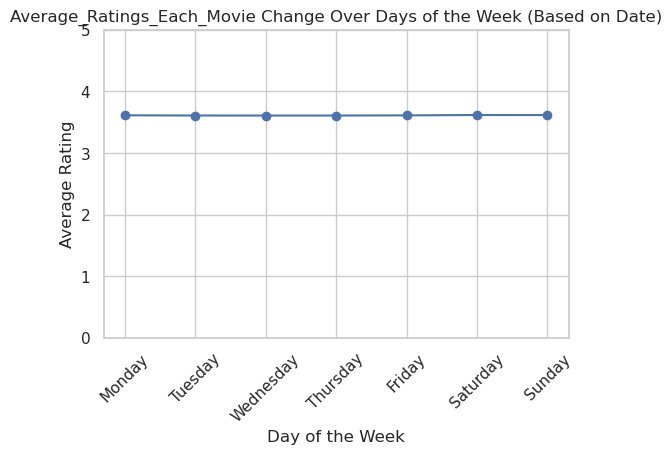

In [88]:
average_ratings_by_day = train_data.groupby(train_data['Date'].dt.dayofweek)['average_ratings_each_movie'].mean()

# Rename the index to days of the week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_ratings_by_day.index = day_names

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_day.index, average_ratings_by_day.values, marker='o')
plt.title('Average_Ratings_Each_Movie Change Over Days of the Week (Based on Date)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.yticks(range(0, 6))
plt.grid(True)
plt.show()

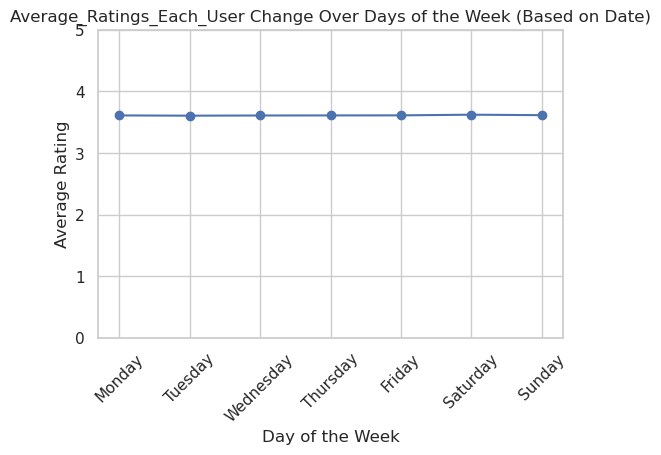

In [89]:
average_ratings_by_day = train_data.groupby(train_data['Date'].dt.dayofweek)['average_ratings_each_user'].mean()

# Rename the index to days of the week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_ratings_by_day.index = day_names

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(average_ratings_by_day.index, average_ratings_by_day.values, marker='o')
plt.title('Average_Ratings_Each_User Change Over Days of the Week (Based on Date)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.yticks(range(0, 6))
plt.grid(True)
plt.show()

<span style="color: yellow;"> The above plots show that while the average 'user_rating', 'average_ratings_each_user' and 'average_ratings_each_movie' doesn't chnage much over the month.

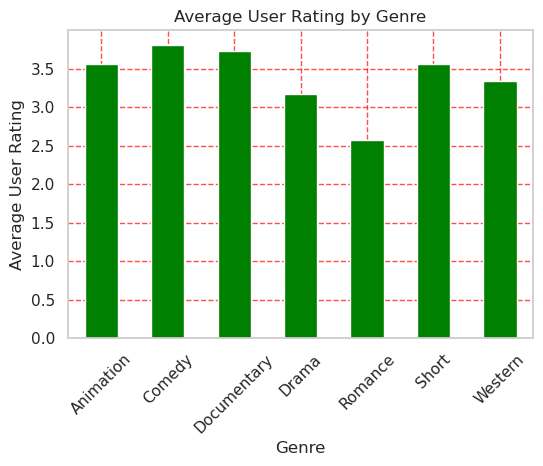

In [91]:
genre_ratings = train_data.groupby('Genre1')['User_Rating'].mean()

# Create a bar graph
plt.figure(figsize=(6, 4))
genre_ratings.plot(kind='bar', color='green')  # You can change the bar color here

plt.title('Average User Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average User Rating')
plt.xticks(rotation=45)

# Add red-colored grid
plt.grid(True, linestyle='--', alpha=0.7, color='red')

plt.show()

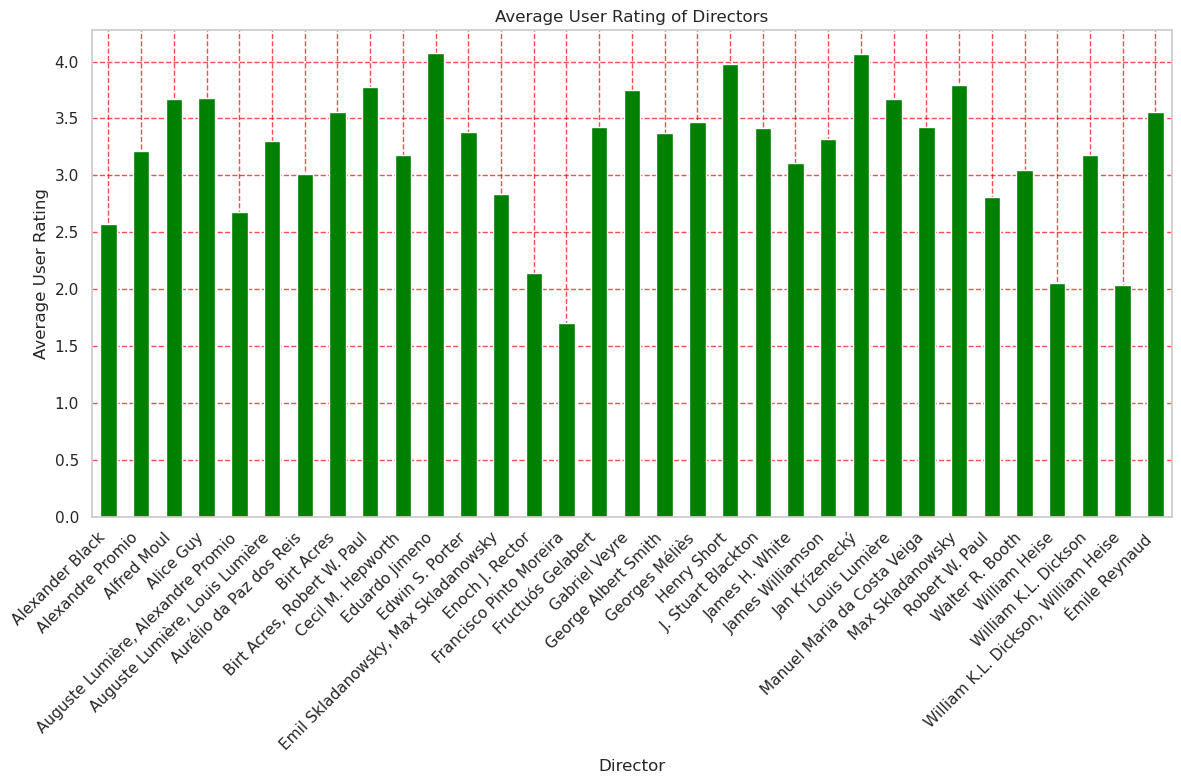

In [97]:
genre_ratings = train_data.groupby('Director1')['User_Rating'].mean()

# Create a bar graph
plt.figure(figsize=(12, 8))
genre_ratings.plot(kind='bar', color='green')  # You can change the bar color here

plt.title('Average User Rating of Directors')
plt.xlabel('Director')
plt.ylabel('Average User Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add red-colored grid
plt.grid(True, linestyle='--', alpha=0.7, color='red')

plt.show()

<span style="color: yellow;"> As the PDF follows a normal distribution we can fill the null values in the test_data for new 'Movie_Title' and 'User_Id' with the mean values of 'average_ratings_each_movie' and 'average_ratings_each_user' respectively.</span>

In [98]:
type(test_data)

pandas.core.frame.DataFrame

In [103]:
train_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26,3.293422,1.0,0.001160,0.001140
1,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27,3.780861,3.0,0.003347,0.142477
2,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27,3.779148,3.0,0.055164,0.101187
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27,3.779148,2.5,0.055164,0.101187
4,61,1999.0,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2000-02-27,2.934783,3.0,0.001916,0.142477


In [100]:
test_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date
800000,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1032429,3,2005-08-18
800001,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2585813,5,2005-08-18
800002,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1205382,5,2005-08-18
800003,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2146820,3,2005-08-18
800004,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,838679,5,2005-08-18


In [131]:

# Calculate median values for the respective columns in train_data
median_of_average_ratings_each_movie = train_data['average_ratings_each_movie'].median()
median_of_average_ratings_each_user = train_data['average_ratings_each_user'].median()
median_of_director_rating_proba = train_data['director_rating_proba'].median()
median_of_genre_rating_proba = train_data['genre_rating_proba'].median()

test_data_new = test_data.copy()

# Create median mappings based on train_data
movie_ratings_map = train_data.groupby(['Movie_Title', 'Genre1', 'Director1'])['average_ratings_each_movie'].median()
user_ratings_map = train_data.groupby(['User_Id', 'Genre1', 'Director1'])['average_ratings_each_user'].median()

director_rating_map = train_data.groupby(['Director1', 'User_Rating']).size().div(len(train_data)).reset_index()
genre_rating_map = train_data.groupby(['Genre1', 'User_Rating']).size().div(len(train_data)).reset_index()

# Create mapping dictionaries for director_rating_proba and genre_rating_proba
director_rating_mapping = director_rating_map.set_index(['Director1', 'User_Rating']).squeeze()
genre_rating_mapping = genre_rating_map.set_index(['Genre1', 'User_Rating']).squeeze()

# For director_rating_proba
def get_director_rating(row):
    key = (row['Director1'], row['User_Rating'])
    return director_rating_mapping.get(key, median_of_director_rating_proba)

test_data_new['director_rating_proba'] = test_data_new.apply(get_director_rating, axis=1)

# For genre_rating_proba
def get_genre_rating(row):
    key = (row['Genre1'], row['User_Rating'])
    return genre_rating_mapping.get(key, median_of_genre_rating_proba)

test_data_new['genre_rating_proba'] = test_data_new.apply(get_genre_rating, axis=1)

# For average_ratings_each_movie
def get_average_movie_rating(row):
    key = (row['Movie_Title'], row['Genre1'], row['Director1'])
    return movie_ratings_map.get(key, median_of_average_ratings_each_movie)

test_data_new['average_ratings_each_movie'] = test_data_new.apply(get_average_movie_rating, axis=1)

# For average_ratings_each_user
def get_average_user_rating(row):
    key = (row['User_Id'], row['Genre1'], row['Director1'])
    return user_ratings_map.get(key, median_of_average_ratings_each_user)

test_data_new['average_ratings_each_user'] = test_data_new.apply(get_average_user_rating, axis=1)

test_data_new.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,director_rating_proba,genre_rating_proba,average_ratings_each_movie,average_ratings_each_user
800000,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1032429,3,2005-08-18,0.003249,0.142478,4.184597,4.0
800001,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2585813,5,2005-08-18,0.002907,0.100430,4.184597,4.0
800002,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1205382,5,2005-08-18,0.002907,0.100430,4.184597,4.0
800003,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2146820,3,2005-08-18,0.003249,0.142478,4.184597,4.0
800004,209,1996.0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,838679,5,2005-08-18,0.002907,0.100430,4.184597,4.0


<span style="color: yellow;"> Let's check a few values to see if they are matching correctly.</span>

In [132]:
test_data_new[test_data_new['Movie_Title']== 'The Three Stooges: Sing a Song of Six Pants'].head(1)

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,director_rating_proba,genre_rating_proba,average_ratings_each_movie,average_ratings_each_user
802933,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1391652,5,2005-08-17,0.002907,0.011246,3.293422,4.0


In [133]:
train_data[train_data['Movie_Title']== 'The Three Stooges: Sing a Song of Six Pants'].head(1)

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26,3.293422,1.0,0.00116,0.00114


In [134]:
train_data[(train_data['Director1']== 'George Albert Smith') & (train_data['User_Rating']== 5)].head(1)

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
55,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1691062,5,2000-02-20,3.293422,5.0,0.002907,0.011246


Before mapping the Movie_Title/ Movie_Id to teh Director1 column of test_data, we need to remove the null values from the Director1 column

In [135]:
test_data.isnull().mean()

Movie_Id       0.0
Year           0.0
Movie_Title    0.0
Director1      0.0
Genre1         0.0
User_Id        0.0
User_Rating    0.0
Date           0.0
dtype: float64

In [136]:
train_data.head()

,Movie_Id,Year,Movie_Title,Director1,Genre1,User_Id,User_Rating,Date,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,208,1947.0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,2000-02-26,3.293422,1.0,0.001160,0.001140
1,18,1994.0,Immortal Beloved,Max Skladanowsky,Short,958687,3,2000-02-27,3.780861,3.0,0.003347,0.142477
2,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,2000-02-27,3.779148,3.0,0.055164,0.101187
3,46,1964.0,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,2000-02-27,3.779148,2.5,0.055164,0.101187
4,61,1999.0,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2000-02-27,2.934783,3.0,0.001916,0.142477


<span style="color: yellow;"> Everything is alright, now we will create a dataframe consisting of 'average_ratings_each_movie', 'average_ratings_each_user' and 'recommended_ratings_each_movie'. The features 'average_ratings_each_movie' and 'average_ratings_each_user' will serve as unique signature for each user which can be used to represent personal biases/ choices from the average population and same also stands for the movies. To make a new dataset let's drop all the unnecessary columns.</span>

In [138]:
train_data_modified= train_data.drop(['Movie_Id', 'Year', 'Date'], axis=1)

train_data_modified.head()

,Movie_Title,Director1,Genre1,User_Id,User_Rating,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,3.293422,1.0,0.001160,0.001140
1,Immortal Beloved,Max Skladanowsky,Short,958687,3,3.780861,3.0,0.003347,0.142477
2,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,3.779148,3.0,0.055164,0.101187
3,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,3.779148,2.5,0.055164,0.101187
4,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2.934783,3.0,0.001916,0.142477


In [139]:
train_data_modified= train_data_modified.reset_index(drop= True)

train_data_modified.head()

,Movie_Title,Director1,Genre1,User_Id,User_Rating,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,3.293422,1.0,0.001160,0.001140
1,Immortal Beloved,Max Skladanowsky,Short,958687,3,3.780861,3.0,0.003347,0.142477
2,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,3.779148,3.0,0.055164,0.101187
3,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,3.779148,2.5,0.055164,0.101187
4,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,2.934783,3.0,0.001916,0.142477


In [140]:
train_data_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Movie_Title                 800000 non-null  object 
 1   Director1                   800000 non-null  object 
 2   Genre1                      800000 non-null  object 
 3   User_Id                     800000 non-null  int32  
 4   User_Rating                 800000 non-null  int32  
 5   average_ratings_each_movie  800000 non-null  float32
 6   average_ratings_each_user   800000 non-null  float32
 7   director_rating_proba       800000 non-null  float32
 8   genre_rating_proba          800000 non-null  float32
dtypes: float32(4), int32(2), object(3)
memory usage: 36.6+ MB


In [146]:
train_data_modified['User_Id']= train_data_modified['User_Id'].astype(str)

In [147]:
train_data_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Movie_Title                 800000 non-null  object 
 1   Director1                   800000 non-null  object 
 2   Genre1                      800000 non-null  object 
 3   User_Id                     800000 non-null  object 
 4   User_Rating                 800000 non-null  int32  
 5   average_ratings_each_movie  800000 non-null  float32
 6   average_ratings_each_user   800000 non-null  float32
 7   director_rating_proba       800000 non-null  float32
 8   genre_rating_proba          800000 non-null  float32
dtypes: float32(4), int32(1), object(4)
memory usage: 39.7+ MB


<span style="color: yellow;"> Let's do the same feature enginering on the test data.</span>

In [142]:
test_data_modified= test_data_new.drop(['Movie_Id', 'Year', 'Date'], axis=1)

test_data_modified.head()

,Movie_Title,Director1,Genre1,User_Id,User_Rating,director_rating_proba,genre_rating_proba,average_ratings_each_movie,average_ratings_each_user
800000,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1032429,3,0.003249,0.142478,4.184597,4.0
800001,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2585813,5,0.002907,0.100430,4.184597,4.0
800002,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1205382,5,0.002907,0.100430,4.184597,4.0
800003,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2146820,3,0.003249,0.142478,4.184597,4.0
800004,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,838679,5,0.002907,0.100430,4.184597,4.0


In [143]:
test_data_modified= test_data_modified.reset_index(drop= True)

test_data_modified.head()

,Movie_Title,Director1,Genre1,User_Id,User_Rating,director_rating_proba,genre_rating_proba,average_ratings_each_movie,average_ratings_each_user
0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1032429,3,0.003249,0.142478,4.184597,4.0
1,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2585813,5,0.002907,0.100430,4.184597,4.0
2,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1205382,5,0.002907,0.100430,4.184597,4.0
3,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2146820,3,0.003249,0.142478,4.184597,4.0
4,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,838679,5,0.002907,0.100430,4.184597,4.0


In [144]:
test_data_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Movie_Title                 200000 non-null  object 
 1   Director1                   200000 non-null  object 
 2   Genre1                      200000 non-null  object 
 3   User_Id                     200000 non-null  int64  
 4   User_Rating                 200000 non-null  int64  
 5   director_rating_proba       200000 non-null  float64
 6   genre_rating_proba          200000 non-null  float64
 7   average_ratings_each_movie  200000 non-null  float32
 8   average_ratings_each_user   200000 non-null  float32
dtypes: float32(2), float64(2), int64(2), object(3)
memory usage: 12.2+ MB


In [148]:
test_data_modified['User_Id']= test_data_modified['User_Id'].astype(str)

<span style="color: yellow;"> Let's scale the data now</span>

In [149]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Assuming 'train_data_modified' is your DataFrame
train_data_scaled = train_data_modified.copy()

# Get the column names before scaling
column_names = train_data_scaled.select_dtypes(include='number').drop(['User_Rating'], axis=1).columns

# Fit the scaler on the entire DataFrame and transform the data
train_data_scaled[column_names] = scaler.fit_transform(train_data_scaled[column_names])

train_data_scaled.head()

,Movie_Title,Director1,Genre1,User_Id,User_Rating,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,The Three Stooges: Sing a Song of Six Pants,George Albert Smith,Comedy,1772362,1,0.646409,0.000,0.009499,0.006720
1,Immortal Beloved,Max Skladanowsky,Short,958687,3,0.783795,0.500,0.027430,0.846322
2,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1673744,3,0.783312,0.500,0.452184,0.601043
3,Rudolph the Red-Nosed Reindeer,Georges Méliès,Documentary,1388677,3,0.783312,0.375,0.452184,0.601043
4,Ricky Martin: One Night Only,Birt Acres,Short,472452,3,0.545325,0.500,0.015698,0.846322


In [160]:
train_data_scaled_modified= train_data_scaled.drop(['Movie_Title',	'User_Id', 'Director1', 'Genre1'], axis=1)

train_data_scaled_modified.head()

,User_Rating,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,1,0.646409,0.000,0.009499,0.006720
1,3,0.783795,0.500,0.027430,0.846322
2,3,0.783312,0.500,0.452184,0.601043
3,3,0.783312,0.375,0.452184,0.601043
4,3,0.545325,0.500,0.015698,0.846322


In [151]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Assuming 'test_data_modified' is your DataFrame
test_data_scaled = test_data_modified.copy()

# Get the column names before scaling
column_names = test_data_scaled.select_dtypes(include='number').drop(['User_Rating'], axis=1).columns

# Fit the scaler on the entire DataFrame and transform the data
test_data_scaled[column_names] = scaler.fit_transform(test_data_scaled[column_names])

test_data_scaled.head()

,Movie_Title,Director1,Genre1,User_Id,User_Rating,director_rating_proba,genre_rating_proba,average_ratings_each_movie,average_ratings_each_user
0,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1032429,3,0.026611,0.846322,0.897589,0.75
1,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2585813,5,0.023813,0.596543,0.897589,0.75
2,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,1205382,5,0.023813,0.596543,0.897589,0.75
3,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,2146820,3,0.026611,0.846322,0.897589,0.75
4,Star Trek: Deep Space Nine: Season 5,George Albert Smith,Short,838679,5,0.023813,0.596543,0.897589,0.75


In [161]:
train_data_scaled_modified= train_data_scaled.drop(['Movie_Title', 'User_Id', 'Director1', 'Genre1'], axis=1)

train_data_scaled_modified.head()

,User_Rating,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,1,0.646409,0.000,0.009499,0.006720
1,3,0.783795,0.500,0.027430,0.846322
2,3,0.783312,0.500,0.452184,0.601043
3,3,0.783312,0.375,0.452184,0.601043
4,3,0.545325,0.500,0.015698,0.846322


In [163]:
# Get the list of column names from train_data
train_columns = train_data_scaled_modified.columns.tolist()

# Reorder columns in test_data to match the order of train_data columns
test_data_scaled_modified = test_data_scaled_modified[train_columns]

test_data_scaled_modified.head()


,User_Rating,average_ratings_each_movie,average_ratings_each_user,director_rating_proba,genre_rating_proba
0,3,0.897589,0.75,0.026611,0.846322
1,5,0.897589,0.75,0.023813,0.596543
2,5,0.897589,0.75,0.023813,0.596543
3,3,0.897589,0.75,0.026611,0.846322
4,5,0.897589,0.75,0.023813,0.596543


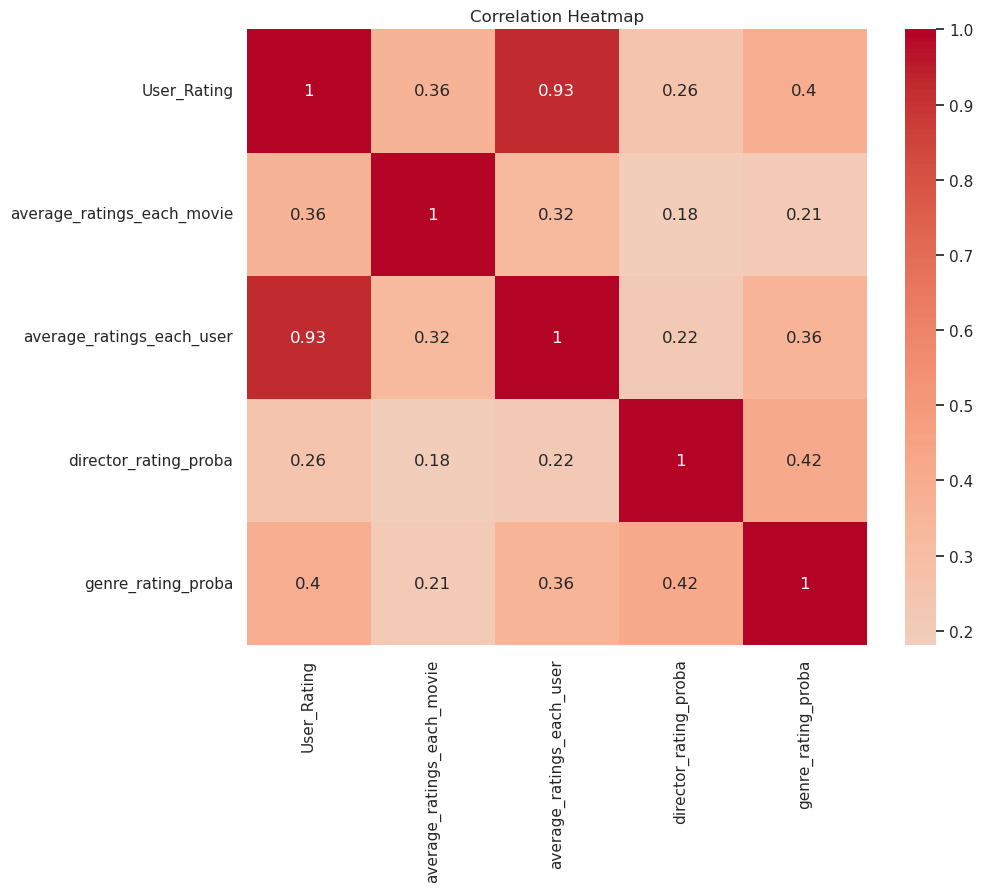

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = train_data_scaled_modified.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


<span style="color: green;"> Building Models</span>

<span style="color: yellow;">First let's try to build it as a linear regression problem, if it doesn't give good result then we treat it as a classification problem and go for logistic regression.</span>

In [180]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target
X = train_data_scaled_modified.drop(['User_Rating'], axis=1)  # Features from scaled DataFrame
y = train_data_scaled_modified['User_Rating']  # Target variable

# Initialize the Ridge (L2 regularized) LinearRegression model with regularization parameter alpha
alpha = 0.01  # Adjust this value based on your preference
model_l2 = Ridge(alpha=alpha)

# Fit the model to the training data
model_l2.fit(X, y)

# Predict target values on the test set
y_pred = model_l2.predict(test_data_scaled_modified.drop(['User_Rating'], axis=1))

# Calculate Mean Squared Error
mse = mean_squared_error(test_data_scaled_modified['User_Rating'], y_pred)

rmse = np.sqrt(mse)

# Calculate R-squared value
r2 = r2_score(test_data_scaled_modified['User_Rating'], y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared value: {r2:.2f}")

Root Mean Squared Error: 1.11
R-squared value: -0.04


In [181]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target
X = train_data_scaled_modified.drop(['User_Rating'], axis=1)  # Features from scaled DataFrame
y = train_data_scaled_modified['User_Rating']  # Target variable

# Initialize the Lasso (L1 regularized) LinearRegression model with regularization parameter alpha
alpha = 0.01  # Adjust this value based on your preference
model_l1 = Lasso(alpha=alpha)

# Fit the model to the training data
model_l1.fit(X, y)

# Predict target values on the test set
y_pred = model_l1.predict(test_data_scaled_modified.drop(['User_Rating'], axis=1))

# Calculate Mean Squared Error
mse = mean_squared_error(test_data_scaled_modified['User_Rating'], y_pred)

rmse = np.sqrt(mse)

# Calculate R-squared value
r2 = r2_score(test_data_scaled_modified['User_Rating'], y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared value: {r2:.2f}")

Root Mean Squared Error: 1.13
R-squared value: -0.06


In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Separate features and target
X = train_data_scaled_modified.drop(['User_Rating'], axis=1)  # Features from scaled DataFrame
y = train_data_scaled_modified['User_Rating']  # Target variable

# Initialize the LogisticRegression model with OvR strategy
model_ovr = LogisticRegression(multi_class='ovr', max_iter=10000)

# Fit the model to the training data
model_ovr.fit(X, y)

# Predict target values on the test set
y_pred = model_ovr.predict(test_data_scaled_modified.drop(['User_Rating'], axis=1))

# Calculate accuracy
accuracy = accuracy_score(test_data_scaled_modified['User_Rating'], y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision, recall, and F1-score
precision = precision_score(test_data_scaled_modified['User_Rating'], y_pred, average='weighted')
recall = recall_score(test_data_scaled_modified['User_Rating'], y_pred, average='weighted')
f1 = f1_score(test_data_scaled_modified['User_Rating'], y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.53
Precision: 0.54
Recall: 0.53
F1-score: 0.44


In [178]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Separate features and target
X = train_data_scaled_modified.drop(['User_Rating'], axis=1)  # Features from scaled DataFrame
y = train_data_scaled_modified['User_Rating']  # Target variable

# Initialize the DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=42, min_samples_leaf= 100)

# Fit the model to the training data
model_dt.fit(X, y)

# Predict target values on the test set
y_pred = model_dt.predict(test_data_scaled_modified.drop(['User_Rating'], axis=1))

# Calculate accuracy
accuracy = accuracy_score(test_data_scaled_modified['User_Rating'], y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision, recall, and F1-score
precision = precision_score(test_data_scaled_modified['User_Rating'], y_pred, average='weighted')
recall = recall_score(test_data_scaled_modified['User_Rating'], y_pred, average='weighted')
f1 = f1_score(test_data_scaled_modified['User_Rating'], y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1-score: 0.92


In [ ]:
# Extract feature importance
feature_importance = model_dt.feature_importances_

# Sort and print feature importance
sorted_indices = np.argsort(feature_importance)[::-1]  # Sort in descending order
for i in sorted_indices:
    print(f"Feature {i}: {feature_importance[i]}")

<span style="color: yellow;"> DecisionTree is showing good Accuracy, Precision, Recall and F1-score values. So we will use DecionTreeClassifier for predicting ratings. We will make a pivot table with 100 Movie_Id and 1000 User_Id from test_data to fill up the pivot table with our DecisionTreeClassifier model. We will make a sample movie recommendation system based on 'User_Rating'.</span>

In [ ]:
num_users_to_select = 1000
num_movies_to_select = 100

# Get unique user IDs and movie IDs from the test_data
unique_user_ids = test_data_scaled['User_Id'].unique()
unique_movie_ids = test_data_scaled['Movie_Title'].unique()

# Randomly select 1000 unique user IDs
selected_user_ids = np.random.choice(unique_user_ids, size=num_users_to_select, replace=False)

# Randomly select 100 movie IDs
selected_movie_ids = np.random.choice(unique_movie_ids, size=num_movies_to_select, replace=False)

# Filter the test_data based on the selected user and movie IDs
filtered_data = test_data_scaled[(test_data_scaled['User_Id'].isin(selected_user_ids)) & (test_data_scaled['Movie_Title'].isin(selected_movie_ids))]

# Create a pivot table using the filtered data
pivot_table = pd.pivot_table(filtered_data, values='recommended_ratings_each_movie', index='User_Id', columns='Movie_Title')

In [ ]:
test_data_scaled.head()

In [ ]:
import pandas as pd

# Create an empty pivot table with user IDs as index and movie titles as columns
pivot_table = pd.pivot_table(test_data_scaled, index='User_Id', columns= 'Movie_Title', values='User_Rating')

# Iterate through the cells of the pivot table
for user_id, row in pivot_table.iterrows():
    for movie_title, cell_value in row.items():
        if pd.isnull(cell_value):  # Check if the cell is empty
            # Retrieve feature values for the corresponding user ID and movie title
            user_features = test_data_scaled.loc[test_data_scaled['User_Id'] == user_id].drop(['User_Id', 'Movie_Title', 'User_Rating'], axis=1)
            movie_features = test_data_scaled.loc[test_data_scaled['movie_title'] == movie_title].drop(['user_id', 'movie_title', 'rating'], axis=1)

            # Predict the value using your Decision Tree Classifier
            predicted_rating = model_dt.predict(user_features)  # Adjust this line as needed

            # Fill the empty cell with the predicted value
            pivot_table.at[user_id, movie_title] = predicted_rating

print(pivot_table)


<span style="color: yellow;">As per the above calculation as the percentage of rated that is actual filled rows are very sparse we can create a sparse matrix of User_Id and Movie_Title to fill the corresponding ratings while filling the non-available ratings as zero.</span>

In [ ]:
from scipy.sparse import csr_matrix, save_npz, load_npz
import os

npz_file_path = r"C:\Users\sandi\Desktop\My Git\Netflix Recommender System\sparse_ratings_matrix_train.npz"

# Check if the NPZ file exists
if os.path.exists(npz_file_path):
    # Load the sparse matrix from the existing NPZ file
    sparse_ratings_matrix_train = load_npz(npz_file_path)
else:
    num_users = np.max(train_data['User_Id'])
    num_movies = np.max(train_data['Movie_Id'])
    sparse_ratings_matrix_train = csr_matrix((train_data['User_Rating'], (train_data['User_Id'], train_data['Movie_Id'])), shape=(num_users + 1, num_movies + 1))

    # Save the sparse matrix as an NPZ file
    save_npz(npz_file_path, sparse_ratings_matrix_train)

# Now you have the sparse matrix loaded or created and loaded
print(sparse_ratings_matrix_train)

In [ ]:
user, movie = sparse_ratings_matrix_train.shape
non_zero_rating = sparse_ratings_matrix_train.count_nonzero()

print(f"Sparsity Of Train matrix : {round(((1-(non_zero_rating/(user*movie))) * 100), 4)}% ")

In [ ]:
from scipy.sparse import csr_matrix, save_npz, load_npz
import os

npz_file_path = r"C:\Users\sandi\Desktop\My Git\Netflix Recommender System\sparse_ratings_matrix_test.npz"

# Check if the NPZ file exists
if os.path.exists(npz_file_path):
    # Load the sparse matrix from the existing NPZ file
    sparse_ratings_matrix_test = load_npz(npz_file_path)
else:
    num_users = np.max(test_data['User_Id'])
    num_movies = np.max(test_data['Movie_Id'])
    sparse_ratings_matrix_test = csr_matrix((test_data['User_Rating'], (test_data['User_Id'], test_data['Movie_Id'])), shape=(num_users + 1, num_movies + 1))

    # Save the sparse matrix as an NPZ file
    save_npz(npz_file_path, sparse_ratings_matrix_test)

# Now you have the sparse matrix loaded or created and loaded
print(sparse_ratings_matrix_test)

In [ ]:
user, movie = sparse_ratings_matrix_test.shape
non_zero_rating = sparse_ratings_matrix_test.count_nonzero()

print(f"Sparsity Of Test matrix : {round(((1-(non_zero_rating/(user*movie))) * 100), 4)}% ")

In [ ]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = sparse_ratings_matrix_train.sum()/sparse_ratings_matrix_train.count_nonzero()
train_averages['global'] = round(train_global_average, 4)
train_averages

In [ ]:
def get_average_ratings(sparse_matrix, of_users):
    # Determine the axis for calculation (1 for users, 0 for movies)
    ax = 1 if of_users else 0

    # Sum of ratings for each user/movie
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1

    # Create a boolean matrix indicating if a user rated a movie
    is_rated = sparse_matrix != 0

    # Number of ratings for each user/movie
    no_of_ratings = is_rated.sum(axis=ax).A1

    # Get the shape of the sparse matrix (max_user, max_movie)
    max_user, max_movie = sparse_matrix.shape

    # Create a dictionary of users/movies and their average ratings
    average_ratings = {
        i: sum_of_ratings[i] / no_of_ratings[i]
        for i in range(max_user if of_users else max_movie)
        if no_of_ratings[i] != 0
                      }

    # Return the dictionary of average ratings
    return average_ratings

In [ ]:
average_ratings_users = get_average_ratings(sparse_ratings_matrix_train, of_users=True)

average_ratings_movies = get_average_ratings(sparse_ratings_matrix_train, of_users=False)

In [ ]:
train_data.head()

In [ ]:
train_averages['User_Id'] = get_average_ratings(sparse_ratings_matrix_train, of_users=True)
print('\nAverage rating of user 510180 :',round(train_averages['User_Id'][510180], 4))

In [ ]:
train_averages['Movie_Id'] = get_average_ratings(sparse_ratings_matrix_train, of_users=False)
print('\nAverage rating of Movie_Id 10341 :',round(train_averages['Movie_Id'][10341], 4))

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.25))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('User Avg Rating')
user_averages = [r for r in train_averages['User_Id'].values()]
sns.kdeplot(user_averages, ax=ax1, cumulative=True, label='CDF')
sns.kdeplot(user_averages, ax=ax1, label='PDF')
ax1.grid(True)  # Adding gridlines to the first subplot

ax2.set_title('Movie Avg Rating')
movie_averages = [r for r in train_averages['Movie_Id'].values()]
sns.kdeplot(movie_averages, ax=ax2, cumulative=True, label='CDF')
sns.kdeplot(movie_averages, ax=ax2, label='PDF')
ax2.grid(True)  # Adding gridlines to the second subplot

plt.show()